# Sentiment Analysis on Movie Reviews

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import string

stem=PorterStemmer()
stop_words=set(stopwords.words('english'))
warnings.filterwarnings("ignore")

## Data Information 

Get the data from kaggle https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

### Attribute Information:

1. Phrase Id
2. Sentence Id
3. Phrase
4. Sentiment

## Objective:- Determine Review Polarity 

Given a review, our main objective is to determine if the review is positive or negative. We can do this by using two approaches.

### 1. Naive Way 

The naive way of doing this is to categorise all reviews with Ratings 3 and 4 as positive. And, all reviews with ratings 0 and 1 as negative. We will ignore all such reviews where the rating is 2 because intuitively if you think about it, 2 is neither positive nor negative. It's a neutral reviews.

### 2. Using review text to decide the polarity 

For this we will perform Natural Language Processing related tasks. We will take the review text, build a Machine Learning model on top of it and predict if new(future) reviews are positive or negative.

## Loading the Data 

In [3]:
data = pd.read_csv('data.tsv.zip', delimiter='\t')
# data= data[1:1000]
print("shape",np.shape(data))
data.head(5)

shape (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
train= data.copy()
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
print("The columns in data are as follows:")
train.dtypes

The columns in data are as follows:


PhraseId       int64
SentenceId     int64
Phrase        object
Sentiment      int64
dtype: object

### Get Mean/Median/Percentile/Standard Deviation information 

In [7]:
#Describe the dataset
train.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


### Checking for null values in data 

In [7]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

### Checking the Duplicate values 

In [8]:
print("The number of Duplicate values :",train.duplicated().sum())

The number of Duplicate values : 0


### Number of reviews corresponding to each of the ratings. 

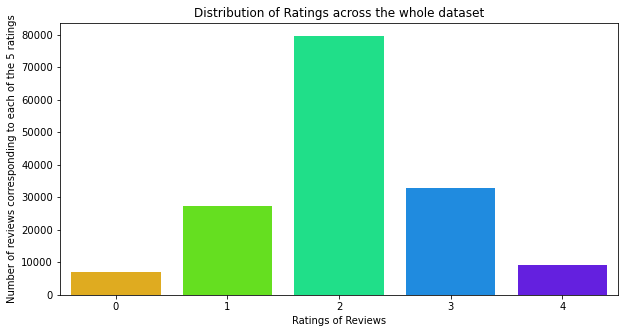

In [9]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.countplot(train['Sentiment'], palette='gist_rainbow')
plt.title("Distribution of Ratings across the whole dataset")
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of the 5 ratings")
plt.show()


In [10]:
print(train['Sentiment'].value_counts())

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


Here, we can see that 50.99% reviews have rating equal to 2, 21.09% reviews have rating equal to 3, 17.47% reviews have rating equal to 1, 5.89% revies have ratings equal to 4 and lastly 4.53% reviews have ratings equal to 0. 

Text(0.5, 1.0, '')

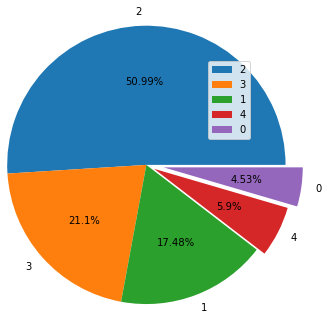

In [11]:
plt.pie(train.Sentiment.value_counts(),radius=1.6,
        labels=train.Sentiment.value_counts().index,
        autopct=lambda x:str(np.round(x,2))+"%",explode=(0,0,0,0.1,0.2))

plt.legend()
plt.title("")

### 1.Naive Way

The naive way of doing this is to categorise all reviews with Ratings 3 and 4 as positive. And, all reviews with ratings 0 and 1 as negative. We will ignore all such reviews where the rating is 2 because intuitively if you think about it, 2 is neither positive nor negative. It's a neutral reviews.

Sentiment as positive or negative

In [12]:
final_data=train
final_data['SentimentPolarity'] = final_data['Sentiment'].apply(lambda x : 'Positive' if x > 2 else 'Negative')
final_data['Class_Labels'] = final_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
final_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,SentimentPolarity,Class_Labels
0,1,1,A series of escapades demonstrating the adage ...,1,Negative,0
1,2,1,A series of escapades demonstrating the adage ...,2,Negative,0
2,3,1,A series,2,Negative,0
3,4,1,A,2,Negative,0
4,5,1,series,2,Negative,0


### 2. Using the review text data and perform Natural Language Processing (NLP) tasks.

Firstly we need to perform some data cleaning and then text preprocessing and convert the texts as vectors so that we can train some model on those vectors and predict polarity of the review

### 1.Data Cleaning 

#### (i) Data Deduplication 

In [14]:
#Get the number of duplicate entries in the dataset.
print("The number of Duplicate values :",final_data.duplicated().sum())

The number of Duplicate values : 0


In [15]:
#Display information about the dataset.
print("The shape of the filtered matrix : {}".format(final_data.shape))
print("The median score values : {}".format(final_data['Sentiment'].mean()))
#print("The number of positive and negative reviews before the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

The shape of the filtered matrix : (156060, 6)
The median score values : 2.0635781109829554
Negative    113927
Positive     42133
Name: SentimentPolarity, dtype: int64


### Text Preprocessing 

#### [1] HTML Tag Removal 

In [16]:
#Function to clean html tags from a sentence
import re
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

removeHtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

' I Want This  text!   '

#### [2] Punctuations Removal 

In [17]:
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

removePunctuations("fsd*?~,,,( sdfsdfdsvv)#")

'fsd        sdfsdfdsvv  '

#### [3] Removal of words with numbers 

In [18]:
#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

removeNumbers("The5 number is removed removed55")

'number is removed'

#### [4] Removal URL from sentences. 

In [19]:
#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)

removeURL("https://www.google.com/search?client=ubuntu&channel=fs&q=google+drive+storage+plans&ie=utf-8&oe=utf-8 notice the URL is removed")

'  notice the URL is removed'

#### [5] Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters. 

In [20]:
#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

removePatterns("This looks soooooooo good! I am so happpyyy")

'This looks  good! I am so '

#### [6] Expand the most common english contractions 

In [21]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

#### [7] Stopwords 

Stop words usually refers to the most common words in a language are generally filtered out before or after processing of natural language data. Sometimes it is avoided to remove the stop words to support phrase search.

In [22]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer



#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = set(['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

custom_stopwords = default_stopwords - excluding

print(custom_stopwords)

{'how', 'am', 'and', 'll', 'himself', 'hers', 'who', 'should', 'itself', 'now', 'all', 'they', 'my', 'ourselves', 'were', 'because', 'by', 'both', 'a', 'i', "that'll", 'during', 'each', 'to', 'at', 'you', 'with', 'ours', 'will', 'when', 'd', "you've", 'so', 'below', 'our', 'that', 'be', 'into', 'there', 'once', 'their', 'too', 'did', 'under', 'does', 'over', 'nor', 'his', 'on', 'we', 'these', 're', 'same', 'being', 'very', 'the', 'had', 'through', 'for', 'do', 'was', 'again', 'me', 'doing', "should've", 'or', 'after', 'out', 'theirs', 'own', 'those', 'only', 'ma', 'but', 'your', 'yourself', 'before', "you'll", 'yourselves', 'y', 't', 'off', 'this', "it's", 'above', 'm', 'are', "she's", 'where', 'yours', 'here', 'he', 'she', 'few', 'which', 'between', 'its', 'it', 'any', 'have', 'themselves', "you're", 's', 'herself', 'them', "you'd", 'him', 'until', 'of', 'down', 'about', 'such', 'having', 'some', 'has', 'o', 'why', "shan't", 'an', 'more', 'is', 'what', 'whom', 'from', 'than', 'while',

#### [8] Stemming

Porter Stemmer: Most commonly used stemmer without a doubt, also one of the most gentle stemmers. Though it is also the most computationally intensive of the algorithms. It is also the oldest stemming algorithm by a large margin.

SnowBall Stemmer(Porter2): Nearly universally regarded as an improvement over porter, and for good reason. Porter himself in fact admits that it is better than his original algorithm. Slightly faster computation time than Porter, with a fairly large community around it.

In [23]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer

## Preprocessing output for one review 

In [24]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final_data['Phrase'][1:2].values: #Running only for 1st review
    filtered_sentence=[]
    print("Review:",sent) #Each review
    sent=removeHtml(sent)# remove HTMl tags
    sent=removePunctuations(sent)# remove Punctuation Symbols
    print("\nReview Split: ",sent.split())
    print()
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in custom_stopwords):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                print()
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                print()
                continue
        else:
            print("Eliminated as it is a numerical value or character of length less than 2")
            print()
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("\nFinally selected words from the review: ",final_string)

Review: A series of escapades demonstrating the adage that what is good for the goose

Review Split:  ['A', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']

================================> A
Eliminated as it is a numerical value or character of length less than 2

================================> series
Selected: Stem Word-> b'seri'

================================> of
Eliminated as it is a numerical value or character of length less than 2

================================> escapades
Selected: Stem Word-> b'escapad'

================================> demonstrating
Selected: Stem Word-> b'demonstr'

================================> the
Eliminated as it is a stopword

================================> adage
Selected: Stem Word-> b'adag'

================================> that
Eliminated as it is a stopword

================================> what
Eliminated as it is a stopword

================================> is
El

100%|████████████████████████████████████████████████████████████████████████| 10222/10222 [00:00<00:00, 990074.25it/s]


Text(0, 0.5, 'Number of Words')

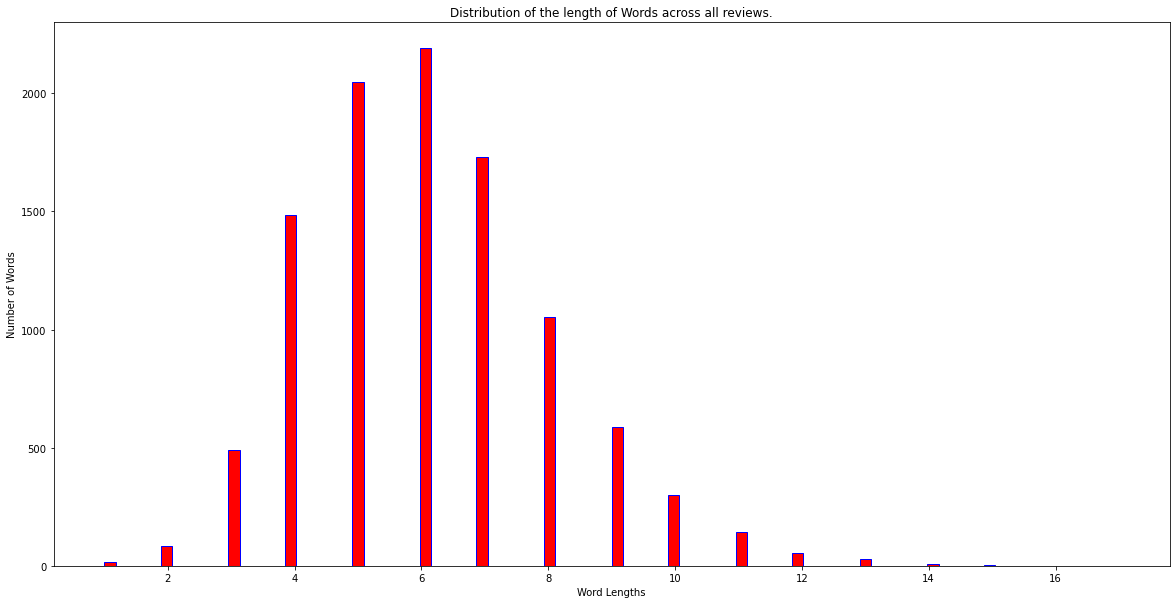

In [25]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
from tqdm import tqdm
total_words = []

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram: 

We can see that most stemmed words present in the reviews has lengths between 3 and 10. Words which has length greater than 13 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 13.

In [26]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1

100%|████████████████████████████████████████████████████████████████████████| 156060/156060 [00:29<00:00, 5334.66it/s]


In [27]:
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

In [28]:
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

The length of the data corpus is : 156060


In [29]:
#No Stemming

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews

count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            cl_word=cleaned_words.lower()                                 
            filtered_sentence.append(cl_word)
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText_NoStem']=preprocessed_reviews

100%|███████████████████████████████████████████████████████████████████████| 156060/156060 [00:08<00:00, 19059.95it/s]


## Preprocessing on all the reviews 

### Positive and Negative words in reviews 

In [30]:
from collections import Counter
print("No. of positive words:",len(all_positive_words))
print("No. of negative words:",len(all_negative_words))
# print("Sample postive words",all_positive_words[:9])
# print("Sample negative words",all_negative_words[:9])
positive = Counter(all_positive_words)
print("\nMost Common postive words",positive.most_common(10))
negative = Counter(all_negative_words)
print("\nMost Common negative words",negative.most_common(10))

No. of positive words: 209024
No. of negative words: 415948

Most Common postive words [('film', 3196), ('movi', 2396), ('not', 1571), ('one', 1406), ('good', 1345), ('make', 1160), ('perform', 1041), ('stori', 1019), ('funni', 987), ('charact', 971)]

Most Common negative words [('not', 6076), ('movi', 5190), ('film', 4635), ('like', 2717), ('one', 2552), ('charact', 1929), ('stori', 1831), ('make', 1808), ('time', 1757), ('rrb', 1741)]


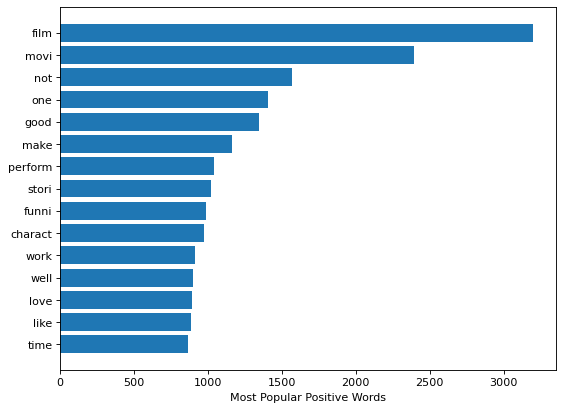

In [31]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
pos_words = positive.most_common(15)
pos_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in pos_words:
    words.append(w)
    times.append(t)
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Positive Words')
plt.show()

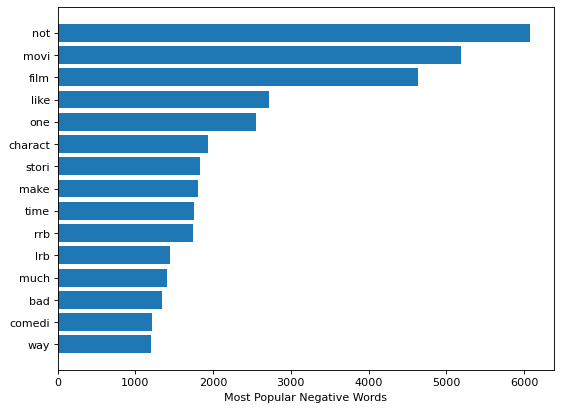

In [32]:
neg_words = negative.most_common(15)
neg_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in neg_words:
    words.append(w)
    times.append(t)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Negative Words')
plt.show()

## Word Cloud of Whole Dataset 

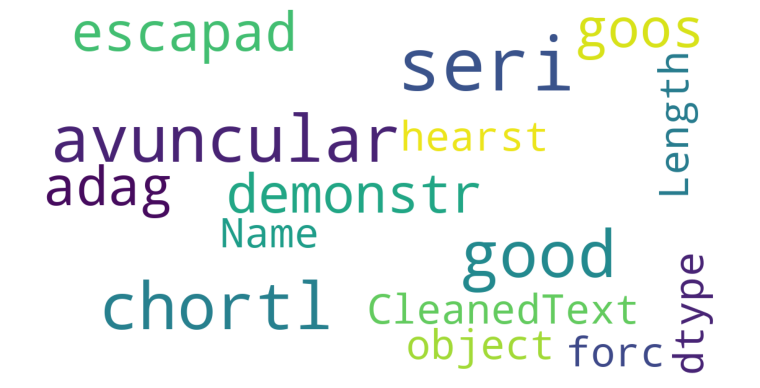

21                                             good goos
22                                                  good
46                                                  amus
63        quiet introspect entertain independ worth seek
64                   quiet introspect entertain independ
                               ...                      
156012                                         great job
156014             anchor charact emot realiti middl age
156023                                       lrb tri rrb
156043                                    dark atmospher
156057                                  avuncular chortl
Name: CleanedText, Length: 42133, dtype: object

In [33]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

df2=final_data

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2['CleanedText'])
df2.loc[df2['SentimentPolarity'] == 'Positive']['CleanedText']

### Word Cloud of only Positive Reviews 

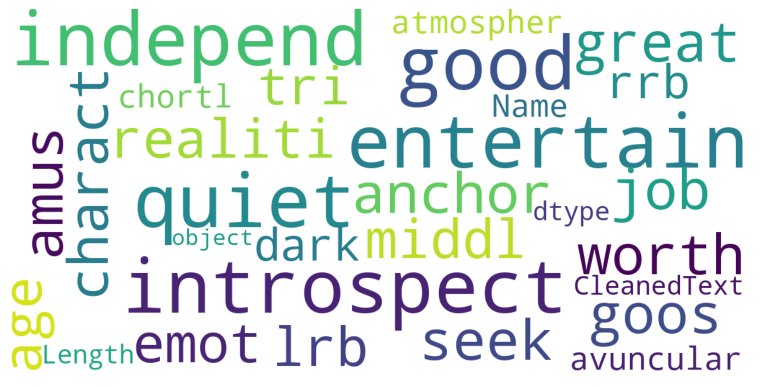

In [34]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2.loc[df2['SentimentPolarity'] == 'Positive']['CleanedText'])

### Word Cloud of only Negative Reviews 

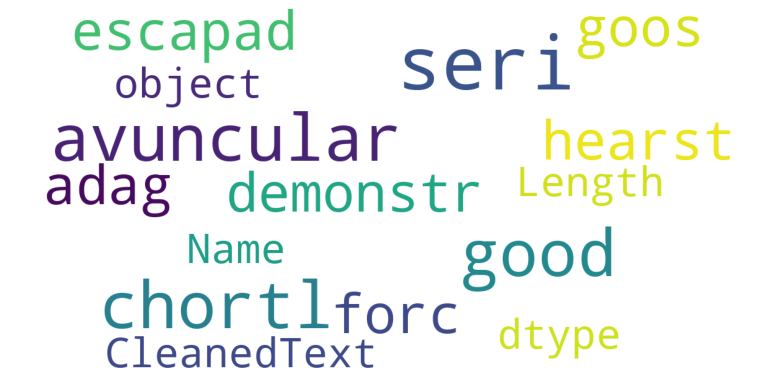

In [35]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2.loc[df2['SentimentPolarity'] == 'Negative']['CleanedText'])